<a href="https://colab.research.google.com/github/flora0110/podcast_segment_headine/blob/main/%E3%80%8Cpodcast_to_headline_del_spon_suger_complete_ipynb%E3%80%8D%E7%9A%84%E5%89%AF%E6%9C%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Textsplit

In [1]:
!pip install word2vec

     |████████████████████████████████| 42 kB 185 kB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for word2vec: filename=word2vec-0.11.1-py2.py3-none-any.whl size=156420 sha256=269117d3084cc9246ec39218e1ba3b6ee8180957fe725126ae948f5ce6ed74e6
  Stored in directory: /root/.cache/pip/wheels/c9/c0/d4/29d797817e268124a32b6cf8beb8b8fe87b86f099d5a049e61
Successfully built word2vec


In [2]:
import os
from gensim.models import word2vec
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

## Download toy corpus for wordvector training and example text

In [3]:
corpus_path = './text8'  # be sure your corpus is cleaned from punctuation and lowercased
if not os.path.exists(corpus_path):
    !wget http://mattmahoney.net/dc/text8.zip
    !unzip {corpus_path}

--2022-05-15 14:29:31--  http://mattmahoney.net/dc/text8.zip
Resolving mattmahoney.net (mattmahoney.net)... 67.195.197.24
Connecting to mattmahoney.net (mattmahoney.net)|67.195.197.24|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31344016 (30M) [application/zip]
Saving to: ‘text8.zip’

text8.zip           100%[===================>]  29.89M   820KB/s    in 38s     

2022-05-15 14:30:10 (806 KB/s) - ‘text8.zip’ saved [31344016/31344016]

Archive:  ./text8.zip
  inflating: text8                   


In [4]:
links = {'podcast_text': 'https://raw.githubusercontent.com/grace-boop/podcast/main/flora_sugar'}  # siddartha

for link in links.values():
    text_path = os.path.basename(link)
    if not os.path.exists(text_path):
        !wget {link}

--2022-05-15 14:30:11--  https://raw.githubusercontent.com/grace-boop/podcast/main/flora_sugar
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 118432 (116K) [text/plain]
Saving to: ‘flora_sugar’

flora_sugar         100%[===================>] 115.66K  --.-KB/s    in 0.01s   

2022-05-15 14:30:11 (9.57 MB/s) - ‘flora_sugar’ saved [118432/118432]



## Train wordvectors

In [5]:
import logging
wrdvec_path = 'wrdvecs.bin'
if not os.path.exists(wrdvec_path):
  sentences = word2vec.Text8Corpus('./text8')
  model = word2vec.Word2Vec(sentences, cbow_mean=1, iter=5, hs=1, sample=0.00001, window=15, size=200)

In [6]:
model.save(wrdvec_path)

In [7]:
model = word2vec.Word2Vec.load(wrdvec_path)
wrdvecs = pd.DataFrame(model.wv.vectors, index=model.wv.vocab)

## get sentence tokenizer

In [8]:
!pip install textsplit

     |████████████████████████████████| 154 kB 8.6 MB/s 


In [9]:
from textsplit.tools import SimpleSentenceTokenizer
sentence_tokenizer = SimpleSentenceTokenizer()

## run get_penalty and split_optimal

In [10]:
%matplotlib inline
from textsplit.tools import get_penalty, get_segments
from textsplit.algorithm import split_optimal, split_greedy, get_total

### podcast

In [11]:
#@title segment target length in sentences { display-mode: "form" }
segment_len =  25#@param {type:"integer"}

penalty 43.18
1218 sentences, 54 segments, avg 22.56 sentences per segment
optimal score 39467.26, greedy score 39374.64
[39467.26085852669, 39374.64330428291]
(39467.26085852669, 39374.64330428291)
ratio of scores 1.0024


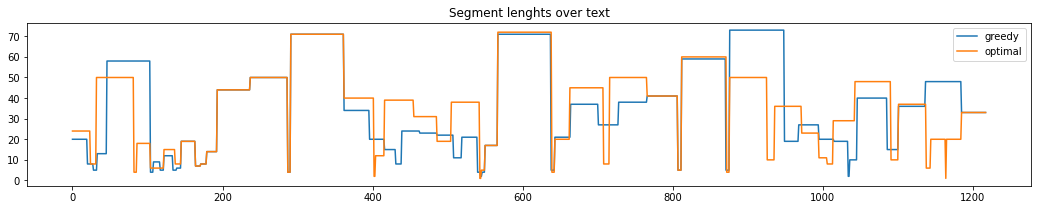

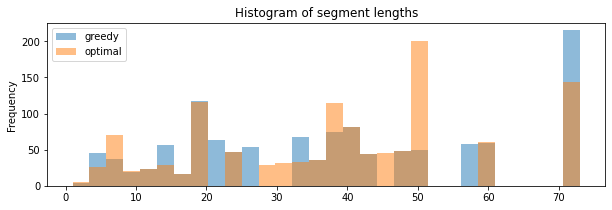

In [12]:
link = links['podcast_text']
book_path = os.path.basename(link)

with open(book_path, 'rt') as f:
    text = f.read()  #.replace('\n', ' ')  # punkt tokenizer handles newlines not so nice

sentenced_text = sentence_tokenizer(text)
strs = " "
for i in range(len(sentenced_text)):
  if(sentenced_text[i] != " "):
    strs =sentenced_text[i]
  if(i+1<len(sentenced_text)):
    if(strs == sentenced_text[i+1]):
      sentenced_text[i+1]=" "
vecr = CountVectorizer(vocabulary=wrdvecs.index)

sentence_vectors = vecr.transform(sentenced_text).dot(wrdvecs)

penalty = get_penalty([sentence_vectors], segment_len)
print('penalty %4.2f' % penalty)

optimal_segmentation = split_optimal(sentence_vectors, penalty, seg_limit=250)
segmented_text = get_segments(sentenced_text, optimal_segmentation)

print('%d sentences, %d segments, avg %4.2f sentences per segment' % (
    len(sentenced_text), len(segmented_text), len(sentenced_text) / len(segmented_text)))

with open(book_path + '.seg', 'wt') as f:
    for i, segment_sentences in enumerate(segmented_text):
        segment_str = ' // '.join(segment_sentences)
        gain = optimal_segmentation.gains[i] if i < len(segmented_text) - 1 else 0
        segment_info = ' [%d sentences, %4.3f] ' % (len(segment_sentences), gain) 
        print(segment_str + '\n8<' + '=' * 30 + segment_info + "=" * 30, file=f)

greedy_segmentation = split_greedy(sentence_vectors, max_splits=len(optimal_segmentation.splits))
greedy_segmented_text = get_segments(sentenced_text, greedy_segmentation)
lengths_optimal = [len(segment) for segment in segmented_text for sentence in segment]
lengths_greedy = [len(segment) for segment in greedy_segmented_text for sentence in segment]
df = pd.DataFrame({'greedy':lengths_greedy, 'optimal': lengths_optimal})
df.plot.line(figsize=(18, 3), title='Segment lenghts over text')
df.plot.hist(bins=30, alpha=0.5, figsize=(10, 3), title='Histogram of segment lengths')

totals = [get_total(sentence_vectors, seg.splits, penalty) 
          for seg in [optimal_segmentation, greedy_segmentation]]
print('optimal score %4.2f, greedy score %4.2f' % tuple(totals))
print(totals)
print(tuple(totals))
print('ratio of scores %5.4f' % (totals[0] / totals[1]))

#### 顯示分段

In [13]:
for i in range(len(segmented_text)):
  print(segmented_text[i])

['Welcome to the huberman Lab podcast. ', 'We discussed science science basic tools for everyday life. ', "I'm Andrew huberman, and I'm a professor of neurobiology and Ophthalmology at Stanford school of medicine. ", 'Today. ', 'We are going to discuss sugar in particular how our nervous system, regulate, our sugar intake and are seeking of sugar. ', "We're also going to discuss how sugar regulates our nervous system and as you'll soon, learn sugar really impacts our brain and body by two main mechanism. ", "One of those mechanisms is based on the Sweet Taste of sugar which itself is rewarding, even if you're not much of a sweet tooth, I confess. ", "I'm not most people enjoy sweet taste more than bitter taste, and the Sweet Taste of sugar. ", 'And its various forms is strongly reinforcing. ', 'Meaning it triggers the activation of neurons nerve cells in the brain and body that make us want to consume more of that sweet substance. ', 'Incidentally sweet taste also make us want to eat m

In [14]:
print(sentenced_text)

['Welcome to the huberman Lab podcast. ', 'We discussed science science basic tools for everyday life. ', "I'm Andrew huberman, and I'm a professor of neurobiology and Ophthalmology at Stanford school of medicine. ", 'Today. ', 'We are going to discuss sugar in particular how our nervous system, regulate, our sugar intake and are seeking of sugar. ', "We're also going to discuss how sugar regulates our nervous system and as you'll soon, learn sugar really impacts our brain and body by two main mechanism. ", "One of those mechanisms is based on the Sweet Taste of sugar which itself is rewarding, even if you're not much of a sweet tooth, I confess. ", "I'm not most people enjoy sweet taste more than bitter taste, and the Sweet Taste of sugar. ", 'And its various forms is strongly reinforcing. ', 'Meaning it triggers the activation of neurons nerve cells in the brain and body that make us want to consume more of that sweet substance. ', 'Incidentally sweet taste also make us want to eat m

### 處理輸入

In [15]:
# 將每個段落內的句子合起來變成string
podcast_test = [""]*len(segmented_text)
for i in range(len(segmented_text)):
  for j in range(len(segmented_text[i])):
    podcast_test[i]+=segmented_text[i][j]

In [16]:
print(podcast_test)

["Welcome to the huberman Lab podcast. We discussed science science basic tools for everyday life. I'm Andrew huberman, and I'm a professor of neurobiology and Ophthalmology at Stanford school of medicine. Today. We are going to discuss sugar in particular how our nervous system, regulate, our sugar intake and are seeking of sugar. We're also going to discuss how sugar regulates our nervous system and as you'll soon, learn sugar really impacts our brain and body by two main mechanism. One of those mechanisms is based on the Sweet Taste of sugar which itself is rewarding, even if you're not much of a sweet tooth, I confess. I'm not most people enjoy sweet taste more than bitter taste, and the Sweet Taste of sugar. And its various forms is strongly reinforcing. Meaning it triggers the activation of neurons nerve cells in the brain and body that make us want to consume more of that sweet substance. Incidentally sweet taste also make us want to eat more of other substances as well. You may

# Headline generator

In [17]:
! pip install transformers datasets

     |████████████████████████████████| 4.2 MB 8.5 MB/s 
     |████████████████████████████████| 342 kB 56.3 MB/s 
     |████████████████████████████████| 596 kB 37.6 MB/s 
     |████████████████████████████████| 84 kB 2.9 MB/s 
     |████████████████████████████████| 6.6 MB 32.5 MB/s 
     |████████████████████████████████| 212 kB 55.7 MB/s 
     |████████████████████████████████| 1.1 MB 38.7 MB/s 
     |████████████████████████████████| 136 kB 46.9 MB/s 
     |████████████████████████████████| 127 kB 7.8 MB/s 
     |████████████████████████████████| 94 kB 3.1 MB/s 
     |████████████████████████████████| 144 kB 43.7 MB/s 
     |████████████████████████████████| 271 kB 31.6 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
ER

In [18]:
!pip install sentencepiece

     |████████████████████████████████| 1.2 MB 8.2 MB/s 


In [19]:
from transformers import pipeline

## 使用Michau/t5-base-en-generate-headline

In [20]:
headlineGenerator = pipeline(model="Michau/t5-base-en-generate-headline", tokenizer="Michau/t5-base-en-generate-headline")

Downloading:   0%|          | 0.00/1.31k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/850M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.74k [00:00<?, ?B/s]

In [21]:
#@title 生成標題的長度 { display-mode: "form" }
min_length =  5#@param {type:"integer"}
max_length = 150#@param {type:"integer"}

In [22]:
headlines = headlineGenerator(podcast_test, min_length, max_length)


Ignoring args : (5, 150)
Token indices sequence length is longer than the specified maximum sequence length for this model (577 > 512). Running this sequence through the model will result in indexing errors


### 顯示結果

In [23]:
for headline in headlines:
  print(headline)
  print(type(headline))

{'generated_text': 'The Ins and Outs of Sugar and Other Foods Today'}
<class 'dict'>
{'generated_text': 'The Brain Body Contract - Live Event in Seattle, Washington on May 17th and Portland,'}
<class 'dict'>
{'generated_text': 'The Nootropics Podcast - Is It Worth It?'}
<class 'dict'>
{'generated_text': 'Insidetracker Insidetracker is a Personal Nutrition Platform That Analyzes Data From'}
<class 'dict'>
{'generated_text': 'Inside Tracker - The Inside Tracker Dashboard'}
<class 'dict'>
{'generated_text': 'Theoretical Principle of More Energy Than We Burn'}
<class 'dict'>
{'generated_text': 'The Effects of Sugar on the Brain'}
<class 'dict'>
{'generated_text': 'Sugar, The Nervous System, And The Nervous System'}
<class 'dict'>
{'generated_text': 'What Happens When We Eat?'}
<class 'dict'>
{'generated_text': 'Glucose is Complete Blood Sugar'}
<class 'dict'>
{'generated_text': 'Insulin Response to Clamp Blood Glucose Levels'}
<class 'dict'>
{'generated_text': 'Glucose is Important for Bra

In [24]:
import re
sentence_tokenizer2 = SimpleSentenceTokenizer()
index=0
headlines_string = [""]*len(headlines)
for headline in headlines:
  sentenced_healine = re.split(r'([;,\.\*\n-])',headline['generated_text'])
  #print(sentenced_healine)
  for i in range(len(sentenced_healine)):
    sentenced_healine[i] = sentenced_healine[i].strip()
    #ss = s1
    #print("!!!"+ss+"!!!")
  print(sentenced_healine)
  strs = " "  
  #headlines_string[index]+=sentenced_healine[0]
  for i in range(0,(len(sentenced_healine))):
    if(sentenced_healine[i] != " "):
      strs = sentenced_healine[i]
      for j in range(i+1,(len(sentenced_healine))):
        if(strs == sentenced_healine[j]):
          sentenced_healine[j]=" "
        #if(sentenced_healine[j] != " "):
          #strs = sentenced_healine[j]
  print(sentenced_healine)
  for k in range(len(sentenced_healine)):
    if(sentenced_healine[k] != " "):
      headlines_string[index]+=" "
      headlines_string[index]+=sentenced_healine[k]
  print(type(headlines_string[index]))
  headlines_string[index]=headlines_string[index].rstrip("-")
  index+=1

['The Ins and Outs of Sugar and Other Foods Today']
['The Ins and Outs of Sugar and Other Foods Today']
<class 'str'>
['The Brain Body Contract', '-', 'Live Event in Seattle', ',', 'Washington on May 17th and Portland', ',', '']
['The Brain Body Contract', '-', 'Live Event in Seattle', ',', 'Washington on May 17th and Portland', ' ', '']
<class 'str'>
['The Nootropics Podcast', '-', 'Is It Worth It?']
['The Nootropics Podcast', '-', 'Is It Worth It?']
<class 'str'>
['Insidetracker Insidetracker is a Personal Nutrition Platform That Analyzes Data From']
['Insidetracker Insidetracker is a Personal Nutrition Platform That Analyzes Data From']
<class 'str'>
['Inside Tracker', '-', 'The Inside Tracker Dashboard']
['Inside Tracker', '-', 'The Inside Tracker Dashboard']
<class 'str'>
['Theoretical Principle of More Energy Than We Burn']
['Theoretical Principle of More Energy Than We Burn']
<class 'str'>
['The Effects of Sugar on the Brain']
['The Effects of Sugar on the Brain']
<class 'str'>


In [25]:
for headline_string in headlines_string:
  print(headline_string)

 The Ins and Outs of Sugar and Other Foods Today
 The Brain Body Contract - Live Event in Seattle , Washington on May 17th and Portland 
 The Nootropics Podcast - Is It Worth It?
 Insidetracker Insidetracker is a Personal Nutrition Platform That Analyzes Data From
 Inside Tracker - The Inside Tracker Dashboard
 Theoretical Principle of More Energy Than We Burn
 The Effects of Sugar on the Brain
 Sugar , The Nervous System And The Nervous System
 What Happens When We Eat?
 Glucose is Complete Blood Sugar
 Insulin Response to Clamp Blood Glucose Levels
 Glucose is Important for Brain Function
 Ketogenic , I'm a Ketoholic I'm a Ke
 Orientation Tuning in the Visual System
 Is It Dependent On Blood Glucose Level?
 Glucose is the Preferable Source of Fuel for the Nervous System
 Fructose Corn Syrup - What Really?
 Is Fructose a Good Thing For Weight Loss?
 The Parallel Pathways in the Brain and Body Control Sugar Cravings
 The Taste of Sugary Taste
 Neuroimaging Study - When You Inhale a Sug

In [26]:
b = "abc, ss dd, www"
a = re.split(r"([,])",b)
print(a)

['abc', ',', ' ss dd', ',', ' www']


# 去掉廣告

In [27]:
!pip install -U scikit-learn
!pip install --user -U nltk

     |████████████████████████████████| 1.5 MB 7.8 MB/s 
     |████████████████████████████████| 749 kB 45.5 MB/s 
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [28]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

## 使用停使用停用詞(NLTK)

In [29]:
# 下面的代碼是使用nltk從句子中去除停用詞 
# 導入包 
import nltk 
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
nltk.download("stopwords")
#set(stopwords.words('english')) 
# 例句 
#text = """He determined to drop his litigation with the monastry, and relinguish his claims to the wood-cuting and fishery rihgts at once. He was the more ready to do this becuase the rights had become much less valuable, and he had indeed the vaguest idea where the wood and river in question were.""" 
# 停用詞集合 
stop_words = set(stopwords.words('english')) 
# 分詞 
nltk.download('punkt')
result_nltk = []
for sent in podcast_test:
  word_tokens = word_tokenize(sent) 
  filtered_sentence = [] 
  for w in word_tokens: 
    if w not in stop_words: 
      filtered_sentence.append(w) 
  result_nltk.append(" ".join(filtered_sentence))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [30]:
print(len(result_nltk))
print(result_nltk)

54
["Welcome huberman Lab podcast . We discussed science science basic tools everyday life . I 'm Andrew huberman , I 'm professor neurobiology Ophthalmology Stanford school medicine . Today . We going discuss sugar particular nervous system , regulate , sugar intake seeking sugar . We 're also going discuss sugar regulates nervous system 'll soon , learn sugar really impacts brain body two main mechanism . One mechanisms based Sweet Taste sugar rewarding , even 're much sweet tooth , I confess . I 'm people enjoy sweet taste bitter taste , Sweet Taste sugar . And various forms strongly reinforcing . Meaning triggers activation neurons nerve cells brain body make us want consume sweet substance . Incidentally sweet taste also make us want eat substances well . You may familiar phenomenon . Now sugar also triggers mechanisms brain body based nutritive content independent . Its sweetness . What means actual caloric content way Sugar interacts nervous system subconscious level without awa

In [31]:
vectorizer_nltk = CountVectorizer()
transformer_nltk = TfidfTransformer()
tfidf_nltk = transformer_nltk.fit_transform(vectorizer_nltk.fit_transform(result_nltk))
feature_name_nltk = vectorizer_nltk.get_feature_names()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [32]:
print(len(feature_name_nltk))
print(feature_name_nltk)

2490
['10', '100', '11', '12', '15', '17th', '18th', '1st', '20', '2012', '30', '3s', '45', '46', '50', '55', '70', '750', '80', '88th', '90', 'ability', 'able', 'absence', 'absolute', 'absolutely', 'abundance', 'abundant', 'accelerator', 'accelerators', 'accept', 'access', 'accident', 'accounting', 'acetylcholine', 'achieve', 'achieving', 'acid', 'acidic', 'acidity', 'acids', 'acknowledge', 'across', 'acting', 'action', 'actionable', 'actions', 'activate', 'activating', 'activation', 'active', 'activities', 'activity', 'actual', 'actually', 'adapted', 'addiction', 'addictive', 'addition', 'additional', 'adhd', 'adjust', 'adjusted', 'adjusting', 'adjustment', 'adrenaline', 'adult', 'adults', 'advanced', 'advantage', 'advantageous', 'affect', 'after', 'ag1', 'again', 'agitated', 'agree', 'agrees', 'ahead', 'aiming', 'alert', 'alkaline', 'alkalinity', 'all', 'allergy', 'allow', 'allowing', 'allows', 'almost', 'alone', 'along', 'already', 'also', 'alter', 'although', 'always', 'am', 'amaz

In [33]:
sponsor_n =0
for i in range(len(feature_name_nltk)):
  if feature_name_nltk[i]=='sponsor':
    sponsor_n =i
    print(i)

2083


In [34]:
# 找出含sponsor的段落內的keyword和其tfidf
from nltk.util import pr
print(type(tfidf_nltk))
keyword_segment = []
tfidf_segment = []
#print(tfidf_nltk)
#print(tfidf_nltk.toarray())
array_tfidf_nltk = tfidf_nltk.toarray()
#print(array_tfidf_nltk)
#print(array_tfidf_nltk[0])
for i in range(len(array_tfidf_nltk)):
  if(array_tfidf_nltk[i][sponsor_n]>0):
    print(i)
    for j in range(len(array_tfidf_nltk[i])):
      if(array_tfidf_nltk[i][j]>0):
        keyword_segment.append(feature_name_nltk[j])
        tfidf_segment.append(array_tfidf_nltk[i][j])
        print(feature_name_nltk[j]," ",array_tfidf_nltk[i][j])

<class 'scipy.sparse.csr.csr_matrix'>
2
10   0.029353290539814718
2012   0.04136493184427289
ability   0.02593344848140411
accept   0.04136493184427289
access   0.06943790740717147
accounting   0.04136493184427289
acknowledge   0.03747728385135839
addition   0.029353290539814718
ag1   0.04136493184427289
alert   0.03747728385135839
all   0.06943790740717147
allow   0.025019603068294587
also   0.03017085920291184
and   0.07584895320017881
around   0.02593344848140411
artist   0.04136493184427289
asian   0.04136493184427289
aspects   0.03257942662209126
associate   0.034718953703585735
athletic   0.28955452290991024
based   0.02418532756998408
basic   0.03747728385135839
been   0.04136493184427289
bees   0.04136493184427289
before   0.03747728385135839
begin   0.04136493184427289
believe   0.0924939171320137
best   0.026943657717756735
biloba   0.04136493184427289
biological   0.03747728385135839
body   0.07527865762485227
brain   0.10346713497066991
bring   0.02807297556289858
brought  

In [35]:
print(keyword_segment)
print(tfidf_segment)

['10', '2012', 'ability', 'accept', 'access', 'accounting', 'acknowledge', 'addition', 'ag1', 'alert', 'all', 'allow', 'also', 'and', 'around', 'artist', 'asian', 'aspects', 'associate', 'athletic', 'based', 'basic', 'been', 'bees', 'before', 'begin', 'believe', 'best', 'biloba', 'biological', 'body', 'brain', 'bring', 'brought', 'calcium', 'called', 'cam', 'cardiovascular', 'changer', 'check', 'chemistry', 'circuits', 'claim', 'clarity', 'code', 'collection', 'com', 'company', 'confidently', 'consumer', 'cooperman', 'cost', 'couple', 'course', 'cover', 'create', 'creativity', 'd3', 'data', 'day', 'deficiencies', 'deficient', 'delighted', 'design', 'desire', 'dha', 'different', 'discover', 'done', 'drink', 'drugs', 'easy', 'effort', 'emphasize', 'energy', 'episode', 'episodes', 'essential', 'even', 'every', 'fail', 'fan', 'far', 'fees', 'first', 'five', 'focused', 'formula', 'formulas', 'four', 'free', 'function', 'functions', 'game', 'general', 'genetics', 'get', 'getting', 'ginkgo', 

In [36]:
# 把含sponsor的後lenth句都作為極有可能是sponaor的區塊
length = 10
sponsor_block = []
for i in range(len(sentenced_text)):
  ws = word_tokenize(sentenced_text[i])
  for w in ws:
    if("sponsor" == w):
      sponsor_block.append(sentenced_text[i])
      for h in range(length):
        if((i+h)<len(sentenced_text)): sponsor_block.append(sentenced_text[i+h])
        
      
sponsor_block = " ".join(sponsor_block)
print(sponsor_block)

Our first sponsor is thesis thesis makes what are called nootropics, which means it's smart.  Our first sponsor is thesis thesis makes what are called nootropics, which means it's smart.  Drugs, be honest.  I'm not a fan of the term nootropics.  I don't believe in smart drugs.  In the sense that I don't believe that there's any one substance, or collection of substances that can make us smarter.  I do believe based on science.  However, that there are particular, neural circuits and brain functions that allow it to be more focused, more alert accept creativity, be more motivated States.  And so the idea of a nootropic that's just going to make us smarter all-around fail, to acknowledge that smarter is many things, right?  If you're an artist or a musician, you're doing math, you're doing accounting a different part of the day you need to be Create a bees are all different.  Brain processing fees understands this. 


In [37]:
# 把sponsor block內的keyword和tdidf記下來
sponsor_word = word_tokenize(sponsor_block)
print(sponsor_word)

keyword_sponsor=[]
tfidf_sponsor=[]
for i in range(len(sponsor_word)):
  if(sponsor_word[i] in keyword_segment and sponsor_word[i] not in keyword_sponsor):
    keyword_sponsor.append(sponsor_word[i])
    tfidf_sponsor.append(tfidf_segment[keyword_segment.index(sponsor_word[i])])
print(len(keyword_sponsor))
print(len(tfidf_sponsor))
n = len(keyword_sponsor)
for i in range(n):
  for j in range(0,n-i-1):
    
    if(tfidf_sponsor[j]>tfidf_sponsor[j+1]):
      tfidf_sponsor[j], tfidf_sponsor[j+1] =  tfidf_sponsor[j+1], tfidf_sponsor[j]
      keyword_sponsor[j], keyword_sponsor[j+1] =  keyword_sponsor[j+1], keyword_sponsor[j]
for i in range(0,n):
  print(keyword_sponsor[i]," ",tfidf_sponsor[i])

['Our', 'first', 'sponsor', 'is', 'thesis', 'thesis', 'makes', 'what', 'are', 'called', 'nootropics', ',', 'which', 'means', 'it', "'s", 'smart', '.', 'Our', 'first', 'sponsor', 'is', 'thesis', 'thesis', 'makes', 'what', 'are', 'called', 'nootropics', ',', 'which', 'means', 'it', "'s", 'smart', '.', 'Drugs', ',', 'be', 'honest', '.', 'I', "'m", 'not', 'a', 'fan', 'of', 'the', 'term', 'nootropics', '.', 'I', 'do', "n't", 'believe', 'in', 'smart', 'drugs', '.', 'In', 'the', 'sense', 'that', 'I', 'do', "n't", 'believe', 'that', 'there', "'s", 'any', 'one', 'substance', ',', 'or', 'collection', 'of', 'substances', 'that', 'can', 'make', 'us', 'smarter', '.', 'I', 'do', 'believe', 'based', 'on', 'science', '.', 'However', ',', 'that', 'there', 'are', 'particular', ',', 'neural', 'circuits', 'and', 'brain', 'functions', 'that', 'allow', 'it', 'to', 'be', 'more', 'focused', ',', 'more', 'alert', 'accept', 'creativity', ',', 'be', 'more', 'motivated', 'States', '.', 'And', 'so', 'the', 'idea',

## 篩選出名詞和形容詞

In [38]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
nltk.download('averaged_perceptron_tagger')
def preprocess(sent):
    sent = nltk.pos_tag(sent)
    return sent
part = preprocess(keyword_sponsor)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [39]:
select_word = []
#part = part.reverse()
for i in range(len(part)):
  if(part[i][1]=='NN' or part[i][1]=='NNS' or part[i][1]=='JJ'or part[i][1]=='JJR'):
    select_word.append(part[i][0])

In [40]:
select_word

['particular',
 'neural',
 'circuits',
 'allow',
 'means',
 'sense',
 'substance',
 'idea',
 'term',
 'substances',
 'functions',
 'alert',
 'many',
 'sponsor',
 'fan',
 'collection',
 'creativity',
 'artist',
 'musician',
 'math',
 'accounting',
 'bees',
 'fees',
 'understands',
 'things',
 'part',
 'day',
 'drugs',
 'smart',
 'nootropic',
 'science',
 'brain',
 'different',
 'thesis',
 'smarter',
 'nootropics']

## 去掉sponsor

In [41]:
for i in range(len(sentenced_text)):
  matches = [a for a in select_word if a in sentenced_text[i]]
  #print(all_sentence[i])
  print(matches)

[]
['day', 'science']
[]
['day']
['particular', 'part']
['brain']
[]
[]
[]
['substance', 'brain']
['substance', 'substances']
[]
['brain']
[]
['means', 'day']
['term', 'brain']
[]
['particular', 'part', 'brain']
[]
['day']
[]
[]
['allow', 'brain']
[]
[]
[]
[]
['part', 'science']
[]
[]
[]
[]
[]
[]
[]
['part', 'science']
['sponsor', 'day']
['means', 'sponsor', 'smart', 'nootropic', 'thesis', 'nootropics']
[]
['term', 'fan', 'nootropic', 'nootropics']
['drugs', 'smart']
['sense', 'substance', 'substances', 'collection', 'smart', 'smarter']
['science']
['particular', 'neural', 'circuits', 'allow', 'functions', 'alert', 'creativity', 'part', 'brain']
['idea', 'many', 'things', 'smart', 'nootropic', 'smarter']
['artist', 'musician', 'math', 'accounting', 'bees', 'part', 'day', 'different']
['fees', 'understands']
['nootropic', 'nootropics']
[]
['things']
['nootropic', 'brain', 'different', 'nootropics']
['idea', 'nootropic', 'brain', 'different', 'nootropics']
[]
['thesis']
[]
[]
[]
['differ

In [56]:
num = 5
match_num=1
before_flag = [0]*num
is_sponsor = []
for i in range(len(sentenced_text)):
  if("sponsor" in sentenced_text[i]):
    
    for j in range(i,len(sentenced_text)):
      matches = [a for a in select_word if a in sentenced_text[j]]
      
      for f in range(num-1,0,-1):
        before_flag[f] = before_flag[f-1]
      if(len(matches)>=match_num or i==j): before_flag[0] = 1
      else: before_flag[0] = 0
      print(before_flag)
      flag=0
      for f in range(num):
        if(before_flag[f]==1): 
          flag=1
          break
      if(flag==1):
        if((j-num+1)>=i): is_sponsor.append(sentenced_text[j-num+1])
        
      else:
        is_sponsor.append("----------------------------------------------------------------")
        break
    break

[1, 0, 0, 0, 0]
[1, 1, 0, 0, 0]
[0, 1, 1, 0, 0]
[1, 0, 1, 1, 0]
[1, 1, 0, 1, 1]
[1, 1, 1, 0, 1]
[1, 1, 1, 1, 0]
[1, 1, 1, 1, 1]
[1, 1, 1, 1, 1]
[1, 1, 1, 1, 1]
[1, 1, 1, 1, 1]
[1, 1, 1, 1, 1]
[0, 1, 1, 1, 1]
[1, 0, 1, 1, 1]
[1, 1, 0, 1, 1]
[1, 1, 1, 0, 1]
[0, 1, 1, 1, 0]
[1, 0, 1, 1, 1]
[0, 1, 0, 1, 1]
[0, 0, 1, 0, 1]
[0, 0, 0, 1, 0]
[1, 0, 0, 0, 1]
[0, 1, 0, 0, 0]
[0, 0, 1, 0, 0]
[1, 0, 0, 1, 0]
[0, 1, 0, 0, 1]
[0, 0, 1, 0, 0]
[0, 0, 0, 1, 0]
[1, 0, 0, 0, 1]
[0, 1, 0, 0, 0]
[1, 0, 1, 0, 0]
[0, 1, 0, 1, 0]
[0, 0, 1, 0, 1]
[0, 0, 0, 1, 0]
[0, 0, 0, 0, 1]
[1, 0, 0, 0, 0]
[0, 1, 0, 0, 0]
[0, 0, 1, 0, 0]
[0, 0, 0, 1, 0]
[0, 0, 0, 0, 1]
[0, 0, 0, 0, 0]


In [57]:
for sent in is_sponsor: 
  print(sent)

I'd like to thank the sponsors of today's podcast. 
Our first sponsor is thesis thesis makes what are called nootropics, which means it's smart. 
Drugs, be honest. 
I'm not a fan of the term nootropics. 
I don't believe in smart drugs. 
In the sense that I don't believe that there's any one substance, or collection of substances that can make us smarter. 
I do believe based on science. 
However, that there are particular, neural circuits and brain functions that allow it to be more focused, more alert accept creativity, be more motivated States. 
And so the idea of a nootropic that's just going to make us smarter all-around fail, to acknowledge that smarter is many things, right? 
If you're an artist or a musician, you're doing math, you're doing accounting a different part of the day you need to be Create a bees are all different. 
Brain processing fees understands this. 
And as far as I know that the first nootropics company to create Target in nootropics for specific outcomes. 
The 

In [58]:
del_sponsor_sentence = []
for i in range(len(sentenced_text)):
  if (sentenced_text[i] not in is_sponsor):
    del_sponsor_sentence.append(sentenced_text[i])
for sent in del_sponsor_sentence: 
  print(sent)

Welcome to the huberman Lab podcast. 
We discussed science science basic tools for everyday life. 
I'm Andrew huberman, and I'm a professor of neurobiology and Ophthalmology at Stanford school of medicine. 
Today. 
We are going to discuss sugar in particular how our nervous system, regulate, our sugar intake and are seeking of sugar. 
We're also going to discuss how sugar regulates our nervous system and as you'll soon, learn sugar really impacts our brain and body by two main mechanism. 
One of those mechanisms is based on the Sweet Taste of sugar which itself is rewarding, even if you're not much of a sweet tooth, I confess. 
I'm not most people enjoy sweet taste more than bitter taste, and the Sweet Taste of sugar. 
And its various forms is strongly reinforcing. 
Meaning it triggers the activation of neurons nerve cells in the brain and body that make us want to consume more of that sweet substance. 
Incidentally sweet taste also make us want to eat more of other substances as well.

# 重新來分段一次

34.38022687534217
penalty 45.49
1182 sentences, 42 segments, avg 28.14 sentences per segment
optimal score 38488.54, greedy score 38417.84
[38488.53586451675, 38417.837989385065]
(38488.53586451675, 38417.837989385065)
ratio of scores 1.0018


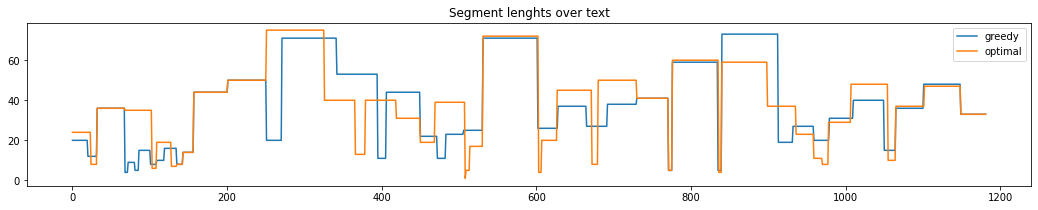

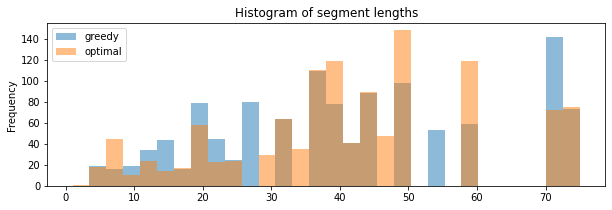

In [59]:
strs = " "
for i in range(len(del_sponsor_sentence)):
  if(del_sponsor_sentence[i] != " "):
    strs =del_sponsor_sentence[i]
  if(i+1<len(del_sponsor_sentence)):
    if(strs == del_sponsor_sentence[i+1]):
      del_sponsor_sentence[i+1]=" "
vecr = CountVectorizer(vocabulary=wrdvecs.index)

sentence_vectors = vecr.transform(del_sponsor_sentence).dot(wrdvecs)
new_length = len(del_sponsor_sentence)**0.5
print(new_length)
penalty = get_penalty([sentence_vectors], new_length)
print('penalty %4.2f' % penalty)

optimal_segmentation = split_optimal(sentence_vectors, penalty, seg_limit=250)
segmented_text = get_segments(del_sponsor_sentence, optimal_segmentation)

print('%d sentences, %d segments, avg %4.2f sentences per segment' % (
    len(del_sponsor_sentence), len(segmented_text), len(del_sponsor_sentence) / len(segmented_text)))

with open(book_path + '.seg', 'wt') as f:
    for i, segment_sentences in enumerate(segmented_text):
        segment_str = ' // '.join(segment_sentences)
        gain = optimal_segmentation.gains[i] if i < len(segmented_text) - 1 else 0
        segment_info = ' [%d sentences, %4.3f] ' % (len(segment_sentences), gain) 
        print(segment_str + '\n8<' + '=' * 30 + segment_info + "=" * 30, file=f)

greedy_segmentation = split_greedy(sentence_vectors, max_splits=len(optimal_segmentation.splits))
greedy_segmented_text = get_segments(del_sponsor_sentence, greedy_segmentation)
lengths_optimal = [len(segment) for segment in segmented_text for sentence in segment]
lengths_greedy = [len(segment) for segment in greedy_segmented_text for sentence in segment]
df = pd.DataFrame({'greedy':lengths_greedy, 'optimal': lengths_optimal})
df.plot.line(figsize=(18, 3), title='Segment lenghts over text')
df.plot.hist(bins=30, alpha=0.5, figsize=(10, 3), title='Histogram of segment lengths')

totals = [get_total(sentence_vectors, seg.splits, penalty) 
          for seg in [optimal_segmentation, greedy_segmentation]]
print('optimal score %4.2f, greedy score %4.2f' % tuple(totals))
print(totals)
print(tuple(totals))
print('ratio of scores %5.4f' % (totals[0] / totals[1]))

In [60]:
for i in range(len(segmented_text)):
  print(segmented_text[i])

['Welcome to the huberman Lab podcast. ', 'We discussed science science basic tools for everyday life. ', "I'm Andrew huberman, and I'm a professor of neurobiology and Ophthalmology at Stanford school of medicine. ", 'Today. ', 'We are going to discuss sugar in particular how our nervous system, regulate, our sugar intake and are seeking of sugar. ', "We're also going to discuss how sugar regulates our nervous system and as you'll soon, learn sugar really impacts our brain and body by two main mechanism. ", "One of those mechanisms is based on the Sweet Taste of sugar which itself is rewarding, even if you're not much of a sweet tooth, I confess. ", "I'm not most people enjoy sweet taste more than bitter taste, and the Sweet Taste of sugar. ", 'And its various forms is strongly reinforcing. ', 'Meaning it triggers the activation of neurons nerve cells in the brain and body that make us want to consume more of that sweet substance. ', 'Incidentally sweet taste also make us want to eat m

In [61]:
# 將每個段落內的句子合起來變成string
podcast_test = [""]*len(segmented_text)
for i in range(len(segmented_text)):
  for j in range(len(segmented_text[i])):
    podcast_test[i]+=segmented_text[i][j]

In [48]:
headlines = headlineGenerator(podcast_test, min_length, max_length)

Ignoring args : (5, 150)


In [49]:
for headline in headlines:
  print(headline)
  

{'generated_text': 'The Ins and Outs of Sugar and Other Foods Today'}
{'generated_text': 'The Brain Body Contract - Live Event in Seattle, Washington on May 17th and Portland,'}
{'generated_text': 'The Inside Tracker Podcast - The Best Nutritional Supplements For Your Brain and Body'}
{'generated_text': 'The Effects of Sugar on the Nervous System'}
{'generated_text': 'Glucose is Complete Blood Sugar'}
{'generated_text': 'Insulin Response to Clamp Blood Glucose Levels'}
{'generated_text': 'Glucose is Important for Brain Function'}
{'generated_text': "Ketogenic, I'm a Ketoholic, I'm a Ke"}
{'generated_text': 'Orientation Tuning in the Visual System'}
{'generated_text': 'Is It Dependent On Blood Glucose Level?'}
{'generated_text': 'Glucose is the Preferable Source of Fuel for the Nervous System'}
{'generated_text': 'Is Fructose a Good Thing?'}
{'generated_text': 'The Parallel Pathways in the Brain and Body Control Sugar Cravings'}
{'generated_text': 'Neuroimaging Study - When You Inhale S

In [50]:
import re
sentence_tokenizer2 = SimpleSentenceTokenizer()
index=0
headlines_string = [""]*len(headlines)
for headline in headlines:
  sentenced_healine = re.split(r'([;,\.\*\n-])',headline['generated_text'])
  #print(sentenced_healine)
  for i in range(len(sentenced_healine)):
    sentenced_healine[i] = sentenced_healine[i].strip()
    #ss = s1
    #print("!!!"+ss+"!!!")
  print(sentenced_healine)
  strs = " "  
  #headlines_string[index]+=sentenced_healine[0]
  for i in range(0,(len(sentenced_healine))):
    if(sentenced_healine[i] != " "):
      strs = sentenced_healine[i]
      for j in range(i+1,(len(sentenced_healine))):
        if(strs == sentenced_healine[j]):
          sentenced_healine[j]=" "
        #if(sentenced_healine[j] != " "):
          #strs = sentenced_healine[j]
  print(sentenced_healine)
  for k in range(len(sentenced_healine)):
    if(sentenced_healine[k] != " "):
      headlines_string[index]+=" "
      headlines_string[index]+=sentenced_healine[k]
  print(type(headlines_string[index]))
  headlines_string[index]=headlines_string[index].rstrip("-")
  index+=1

['The Ins and Outs of Sugar and Other Foods Today']
['The Ins and Outs of Sugar and Other Foods Today']
<class 'str'>
['The Brain Body Contract', '-', 'Live Event in Seattle', ',', 'Washington on May 17th and Portland', ',', '']
['The Brain Body Contract', '-', 'Live Event in Seattle', ',', 'Washington on May 17th and Portland', ' ', '']
<class 'str'>
['The Inside Tracker Podcast', '-', 'The Best Nutritional Supplements For Your Brain and Body']
['The Inside Tracker Podcast', '-', 'The Best Nutritional Supplements For Your Brain and Body']
<class 'str'>
['The Effects of Sugar on the Nervous System']
['The Effects of Sugar on the Nervous System']
<class 'str'>
['Glucose is Complete Blood Sugar']
['Glucose is Complete Blood Sugar']
<class 'str'>
['Insulin Response to Clamp Blood Glucose Levels']
['Insulin Response to Clamp Blood Glucose Levels']
<class 'str'>
['Glucose is Important for Brain Function']
['Glucose is Important for Brain Function']
<class 'str'>
['Ketogenic', ',', "I'm a Ke

In [51]:
for headline_string in headlines_string:
  print(headline_string)

 The Ins and Outs of Sugar and Other Foods Today
 The Brain Body Contract - Live Event in Seattle , Washington on May 17th and Portland 
 The Inside Tracker Podcast - The Best Nutritional Supplements For Your Brain and Body
 The Effects of Sugar on the Nervous System
 Glucose is Complete Blood Sugar
 Insulin Response to Clamp Blood Glucose Levels
 Glucose is Important for Brain Function
 Ketogenic , I'm a Ketoholic I'm a Ke
 Orientation Tuning in the Visual System
 Is It Dependent On Blood Glucose Level?
 Glucose is the Preferable Source of Fuel for the Nervous System
 Is Fructose a Good Thing?
 The Parallel Pathways in the Brain and Body Control Sugar Cravings
 Neuroimaging Study - When You Inhale Something Sweet , You Taste It
 Dopamine , a Neuromodulator Is a Molecular Activator
 Dopamine and the Pleasure - Pain Balance
 Dopamine - The Secret of Sex and Reproduction
 The Subconscious Circuits for Sugar Perception
 So this experiment is so crucial . 
 Post Injective Effect - What Is 

In [52]:
len(headlines_string)

41

In [53]:
print(headlines_string)
3

[' The Ins and Outs of Sugar and Other Foods Today', ' The Brain Body Contract - Live Event in Seattle , Washington on May 17th and Portland ', ' The Inside Tracker Podcast - The Best Nutritional Supplements For Your Brain and Body', ' The Effects of Sugar on the Nervous System', ' Glucose is Complete Blood Sugar', ' Insulin Response to Clamp Blood Glucose Levels', ' Glucose is Important for Brain Function', " Ketogenic , I'm a Ketoholic I'm a Ke", ' Orientation Tuning in the Visual System', ' Is It Dependent On Blood Glucose Level?', ' Glucose is the Preferable Source of Fuel for the Nervous System', ' Is Fructose a Good Thing?', ' The Parallel Pathways in the Brain and Body Control Sugar Cravings', ' Neuroimaging Study - When You Inhale Something Sweet , You Taste It', ' Dopamine , a Neuromodulator Is a Molecular Activator', ' Dopamine and the Pleasure - Pain Balance', ' Dopamine - The Secret of Sex and Reproduction', ' The Subconscious Circuits for Sugar Perception', ' So this exper

3

In [54]:
first_sentence = []
for i in range(len(segmented_text)):
  first_sentence.append(segmented_text[i][0].strip().rstrip().rstrip('.'))
  print(segmented_text[i][0])
  print(type(segmented_text[i][0]))
  print(len(segmented_text[i]))

Welcome to the huberman Lab podcast. 
<class 'str'>
24
This May 1st. 
<class 'str'>
8
You can access tickets by going to huberman lab.com tour. 
<class 'str'>
58
I don't know that there's anyone that really debates that anymore, even if we just agree and I think we should all agree on the so-called calories in calories out, principle of thermodynamics more energy than we burn. 
<class 'str'>
35
Blood. 
<class 'str'>
6
Assuming that you have a normal insulin response that you're not diabetic that insulin response would help clamp that blood glucose level so that it did not cause damage to your brain and body. 
<class 'str'>
19
That's what allows those neurons to fire electrical, potentials. 
<class 'str'>
7
There are ingesting, some starch or carbohydrate. 
<class 'str'>
8
But for my entire life up until now, I'm 46 years old. 
<class 'str'>
14
And everything that you see, whether it's a face or a dog or a cat, or landscape is built up from these very simple. 
<class 'str'>
44
Typically

In [55]:
print(first_sentence)
print(len((first_sentence)))

['Welcome to the huberman Lab podcast', 'This May 1st', 'You can access tickets by going to huberman lab.com tour', "I don't know that there's anyone that really debates that anymore, even if we just agree and I think we should all agree on the so-called calories in calories out, principle of thermodynamics more energy than we burn", 'Blood', "Assuming that you have a normal insulin response that you're not diabetic that insulin response would help clamp that blood glucose level so that it did not cause damage to your brain and body", "That's what allows those neurons to fire electrical, potentials", 'There are ingesting, some starch or carbohydrate', "But for my entire life up until now, I'm 46 years old", "And everything that you see, whether it's a face or a dog or a cat, or landscape is built up from these very simple", 'Typically, you are going to use fuels that are available to the neuron based on your intake of food', 'Fructose, of course, is found in fruit', 'That your body is 